# Base

In [29]:
import pandas as pd

df = pd.read_csv('Data/cell2cell-duke univeristy.csv')
df = df.drop(columns=['Unnamed: 0', 'X', 'customer', 'churndep', 'traintest'])
df

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,...,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
0,0,57.492500,482.75,37.424999,0.2475,22.75,0.0,532.25,50.987499,8.333333,...,0,0,1,0,0,5,0,0,149.989990,0
1,0,82.275002,1312.25,75.000000,1.2375,0.00,0.0,156.75,8.145000,52.000000,...,0,1,0,0,0,6,0,0,9.989998,0
2,0,31.662500,25.50,29.990000,0.2475,0.00,0.0,59.50,4.027500,0.000000,...,0,0,1,0,0,9,0,0,29.989990,0
3,0,62.127499,97.50,65.985001,2.4750,0.00,0.0,23.50,6.822500,0.000000,...,0,1,0,0,0,6,0,0,29.989990,0
4,0,25.225000,2.50,25.000000,0.0000,0.00,0.0,-2.50,-0.225000,0.000000,...,0,1,0,0,0,7,0,0,29.989990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71042,1,117.489998,384.00,29.990000,0.0000,250.00,0.0,0.00,0.000000,4.000000,...,0,0,0,0,0,2,0,0,29.989990,0
71043,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0,0,0,0,0,6,0,1,0.000000,0
71044,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.333333,...,0,0,0,0,0,6,0,0,59.989990,0
71045,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0,1,0,0,0,8,0,1,0.000000,0


In [30]:
df= df.dropna()

In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

y = df['churn'].astype(int)

df = pd.DataFrame(df)
label_encoder = LabelEncoder()

    
X=df.drop(['churn'], axis=1)

In [32]:
import numpy as np
import optuna
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
from imblearn.over_sampling import SMOTE

# Ghi lại thời gian bắt đầu toàn bộ quá trình chạy
overall_start_time = time.time()

# Chia tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để cân bằng dữ liệu huấn luyện
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

def objective(trial):
    """Hàm mục tiêu Optuna để tìm siêu tham số tối ưu."""
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tối ưu siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Thiết lập số lần thử là 200

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian thực hiện tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian chạy tìm kiếm siêu tham số: {total_time:.2f} Giây")

# Lấy ra siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tối ưu:", best_params)

# Huấn luyện lại mô hình với siêu tham số tối ưu
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_resampled, y_resampled)

# Thực hiện dự đoán
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính các chỉ số đánh giá
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình chạy
overall_end_time = time.time()

# Tính tổng thời gian chạy toàn bộ
overall_total_time = overall_end_time - overall_start_time
print(f"Toàn bộ thời gian chạy: {overall_total_time:.2f} Giây")


[I 2025-07-08 21:14:49,665] A new study created in memory with name: no-name-18a4b92d-20a4-460c-8f7d-dcaea76c11d4
[I 2025-07-08 21:16:31,686] Trial 0 finished with value: 0.6417456956198251 and parameters: {'n_estimators': 428, 'max_depth': 39, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6417456956198251.
[I 2025-07-08 21:16:42,948] Trial 1 finished with value: 0.604638143248101 and parameters: {'n_estimators': 108, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6417456956198251.
[I 2025-07-08 21:17:20,325] Trial 2 finished with value: 0.6381001463606152 and parameters: {'n_estimators': 183, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6417456956198251.
[I 2025-07-08 21:17:39,237] Trial 3 finished with value: 0.6355477262803926 and parameters: {'n_estimators': 120, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value

Thời gian chạy tìm kiếm siêu tham số: 466.15 Giây
Siêu tham số tối ưu: {'n_estimators': 428, 'max_depth': 39, 'min_samples_split': 15, 'min_samples_leaf': 4}
AUC: 0.6417456956198251
Accuracy: 0.6918915019477709
Precision: 0.42616033755274263
Recall: 0.20245552493109498
F1 Score: 0.27450314251741126
Matthews Correlation Coefficient: 0.12153943983140696

Ma trận nhầm lẫn:
[[8783 1088]
 [3183  808]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      9871
           1       0.43      0.20      0.27      3991

    accuracy                           0.69     13862
   macro avg       0.58      0.55      0.54     13862
weighted avg       0.65      0.69      0.65     13862

Toàn bộ thời gian chạy: 579.39 Giây


In [33]:
import numpy as np
import optuna
import time
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
from imblearn.over_sampling import SMOTE

# Ghi lại thời gian bắt đầu toàn bộ quá trình
overall_start_time = time.time()

# Chia tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Tính toán scale_pos_weight (có thể dùng nếu không dùng SMOTE)
# scale_pos_weight = sum(y_resampled == 0) / sum(y_resampled == 1)

def objective(trial):
    """Hàm mục tiêu Optuna để tìm siêu tham số tối ưu."""
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        # scale_pos_weight=scale_pos_weight,  # Dành cho dữ liệu không cân bằng
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        verbosity=0,
        use_label_encoder=False
    )
    
    model.fit(X_resampled, y_resampled)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tìm kiếm siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # Thiết lập chạy 200 lần thử

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian chạy tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian chạy tìm kiếm siêu tham số: {total_time:.2f} Giây")

# Lấy ra siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tối ưu:", best_params)

# Huấn luyện lại mô hình với siêu tham số tối ưu
best_model = xgb.XGBClassifier(
    objective='binary:logistic',
    # scale_pos_weight=scale_pos_weight,
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    verbosity=0,
    use_label_encoder=False
)
best_model.fit(X_resampled, y_resampled)

# Dự đoán
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính toán các chỉ số đánh giá
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình
overall_end_time = time.time()

# Tính tổng thời gian chạy toàn bộ
overall_total_time = overall_end_time - overall_start_time
print(f"Toàn bộ thời gian chạy: {overall_total_time:.2f} Giây")


[I 2025-07-08 21:24:29,308] A new study created in memory with name: no-name-a87a4519-80cb-4e21-a853-dc55bb75c5d9
[I 2025-07-08 21:24:30,202] Trial 0 finished with value: 0.66244533180103 and parameters: {'max_depth': 5, 'learning_rate': 0.07736128139316392, 'n_estimators': 235}. Best is trial 0 with value: 0.66244533180103.
[I 2025-07-08 21:24:31,881] Trial 1 finished with value: 0.6578145092489913 and parameters: {'max_depth': 7, 'learning_rate': 0.14882413875953449, 'n_estimators': 319}. Best is trial 0 with value: 0.66244533180103.
[I 2025-07-08 21:24:34,586] Trial 2 finished with value: 0.6633879094947727 and parameters: {'max_depth': 10, 'learning_rate': 0.04449559848293163, 'n_estimators': 254}. Best is trial 2 with value: 0.6633879094947727.
[I 2025-07-08 21:24:36,196] Trial 3 finished with value: 0.6615540167484021 and parameters: {'max_depth': 5, 'learning_rate': 0.2198284834877066, 'n_estimators': 453}. Best is trial 2 with value: 0.6633879094947727.
[I 2025-07-08 21:24:37,0

Thời gian chạy tìm kiếm siêu tham số: 228.37 Giây
Siêu tham số tối ưu: {'max_depth': 4, 'learning_rate': 0.1790966618152872, 'n_estimators': 399}
AUC: 0.6709759480358514
Accuracy: 0.7123070264031164
Precision: 0.5008488964346349
Recall: 0.22174893510398397
F1 Score: 0.3073984022229941
Matthews Correlation Coefficient: 0.17975295181918813

Ma trận nhầm lẫn:
[[8989  882]
 [3106  885]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      9871
           1       0.50      0.22      0.31      3991

    accuracy                           0.71     13862
   macro avg       0.62      0.57      0.56     13862
weighted avg       0.67      0.71      0.67     13862

Toàn bộ thời gian chạy: 230.12 Giây


In [36]:
import numpy as np
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(X_train)


#Get shap value summary
shap_values
result = [np.mean([abs(items[i]) for items in shap_values]) for i in range(len(shap_values[0]))]

#Get column name
X.columns
result
# DataFrame
df = pd.DataFrame({'Feature': X.columns, 'mean|shap value|': result})
sorted_df = df.sort_values(by='mean|shap value|',ascending=False)
# DataFrame
display(sorted_df)
sorted_df.to_csv("shap_values_sorted.csv", index=False)


,Feature,mean|shap value|
26,eqpdays,0.392297
1,mou,0.273836
21,months,0.268354
6,changem,0.190339
24,phones,0.155664
...,...,...
51,mailflag,0.001430
19,callfwdv,0.000802
62,mcycle,0.000759
43,occhmkr,0.000456


# Highly Associated Fuzzy Churn Patterns in Binary Classification

## Fuzzy Triangle & Gaussion

In [37]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Data/cell2cell-duke univeristy.csv')
df = df.drop(columns=['Unnamed: 0', 'X', 'customer', 'churndep', 'traintest'])
df = df.dropna()
#print(df_encoded.columns)
y = df['churn'].astype(int)
#df_encoded = df.astype(float)
#df_encoded
#X=df_encoded.drop(['Churn'], axis=1)

df = pd.DataFrame(df)

# LabelEncoder
label_encoder = LabelEncoder()

    
X=df.drop(['churn'], axis=1)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_temp=pd.concat([X_temp,y_temp],axis=1)
X=X_temp[X_temp['churn']==1]

X

,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,...,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall,churn
64085,90.654999,1050.00,10.000000,0.0000,175.75,6.6450,-35.00,-0.635000,18.666666,3.000000,...,0,0,0,0,7,0,0,59.989990,0,1
67677,35.435001,372.50,44.990002,0.0000,0.75,0.1725,65.50,0.255000,0.666667,0.666667,...,0,0,1,0,6,1,0,99.989990,0,1
60770,35.334999,361.00,44.990002,0.2475,0.25,0.0000,268.00,0.045000,3.666667,0.333333,...,0,0,0,0,3,0,0,149.989990,0,1
53271,49.557499,570.25,59.990002,0.7425,3.50,0.0000,18.75,0.432500,2.000000,0.666667,...,0,0,0,0,9,0,0,29.989990,0,1
59487,69.912498,456.50,47.650002,0.0000,0.75,0.7525,-257.50,30.077499,5.666667,0.666667,...,0,0,1,0,8,0,0,149.989990,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54274,43.542500,175.75,30.000000,0.4950,36.50,0.0000,-163.75,-13.542500,2.333333,0.000000,...,1,0,0,0,4,0,0,149.989990,0,1
61904,140.972504,1545.75,59.990002,1.9800,213.25,0.7050,654.25,181.877502,8.666667,6.666667,...,0,0,0,1,0,0,1,0.000000,0,1
70834,28.000000,51.25,16.990000,0.2475,30.75,0.0000,-24.25,-8.560000,0.666667,0.333333,...,0,0,0,0,9,0,0,9.989998,0,1
55849,78.892502,528.00,44.990002,1.7325,112.00,2.9700,475.00,90.207497,0.000000,0.666667,...,0,0,0,0,9,0,0,149.989990,0,1


In [38]:
def print_column_names(X):
    print("Các cột trong DataFrame là:")
    print(list(X.columns))
print_column_names(X)

Các cột trong DataFrame là:
['revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem', 'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway', 'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk', 'callfwdv', 'callwait', 'months', 'uniqsubs', 'actvsubs', 'phones', 'models', 'eqpdays', 'age1', 'age2', 'children', 'credita', 'creditaa', 'prizmrur', 'prizmub', 'prizmtwn', 'refurb', 'webcap', 'truck', 'rv', 'occprof', 'occcler', 'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'ownrent', 'marryun', 'marryyes', 'mailord', 'mailres', 'mailflag', 'travel', 'pcown', 'creditcd', 'retcalls', 'retaccpt', 'newcelly', 'newcelln', 'refer', 'incmiss', 'income', 'mcycle', 'setprcm', 'setprc', 'retcall', 'churn']


In [40]:
X.shape

(15895, 67)

In [41]:

Xtofuzzy_Tri  = X[['revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem', 'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway', 'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk', 'callfwdv', 'callwait', 'months', 'uniqsubs', 'actvsubs', 'phones', 'models', 'eqpdays', 'age1', 'age2', 'children', 'credita', 'creditaa', 'prizmrur', 'prizmub', 'prizmtwn', 'refurb', 'webcap', 'truck', 'rv', 'occprof', 'occcler', 'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'ownrent', 'marryun', 'marryyes', 'mailord', 'mailres', 'mailflag', 'travel', 'pcown', 'creditcd', 'retcalls', 'retaccpt', 'newcelly', 'newcelln', 'refer', 'incmiss', 'income', 'mcycle', 'setprcm', 'setprc', 'retcall']]

In [42]:
import pandas as pd

# Membership function
def triangular_mf(x, a, b, c):
    if x <= a:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x <= c:
        return (c - x) / (c - b)
    else:
        return 0

# Maximal cardinality
def fuzzy_classification(x, min_val, median_val, max_val):
    low_membership = triangular_mf(x, min_val, min_val, median_val)
    medium_membership = triangular_mf(x, min_val, median_val, max_val)
    high_membership = triangular_mf(x, median_val, max_val, max_val)
    
    max_membership = max(low_membership, medium_membership, high_membership)
    
    if max_membership == low_membership:
        return 0
    elif max_membership == medium_membership:
        return 1
    else:
        return 2
  
    
fuzzy_df = pd.DataFrame()
# For each feature
for feature in Xtofuzzy_Tri.columns:
    min_val = Xtofuzzy_Tri[feature].min()
    median_val = Xtofuzzy_Tri[feature].quantile(0.5)
    max_val = Xtofuzzy_Tri[feature].max()
    
    fuzzy_df[f'{feature}_fuzzy'] = Xtofuzzy_Tri[feature].apply(lambda x: fuzzy_classification(x, min_val, median_val, max_val))

fuzzy_df

# Define a dict
boundaries = {}

for feature in Xtofuzzy_Tri.columns:
    min_val = Xtofuzzy_Tri[feature].min()
    median_val = Xtofuzzy_Tri[feature].quantile(0.5)
    max_val = Xtofuzzy_Tri[feature].max()
    
    # Save
    boundaries[feature] = (min_val, median_val, max_val)

# print out
for feature, bounds in boundaries.items():
    print(f"Feature: {feature}")
    print(f"Low boundary: {bounds[0]}, Medium boundary: {bounds[1]}, High boundary: {bounds[2]}")
    print("------")

fuzzy_df

Feature: revenue
Low boundary: 3.467499971, Medium boundary: 47.63249969, High boundary: 861.1049805
------
Feature: mou
Low boundary: 0.0, Medium boundary: 330.0, High boundary: 5409.75
------
Feature: recchrge
Low boundary: -6.050000191, Medium boundary: 44.47000122, High boundary: 337.9750061
------
Feature: directas
Low boundary: 0.0, Medium boundary: 0.247500002, High boundary: 46.52999878
------
Feature: overage
Low boundary: 0.0, Medium boundary: 3.5, High boundary: 2018.0
------
Feature: roam
Low boundary: 0.0, Medium boundary: 0.0, High boundary: 850.8624878
------
Feature: changem
Low boundary: -2867.5, Medium boundary: -10.0, High boundary: 5192.25
------
Feature: changer
Low boundary: -851.1049805, Medium boundary: -0.292499989, High boundary: 2483.482422
------
Feature: dropvce
Low boundary: 0.0, Medium boundary: 3.0, High boundary: 208.6666718
------
Feature: blckvce
Low boundary: 0.0, Medium boundary: 1.0, High boundary: 314.6666565
------
Feature: unansvce
Low boundary:

,revenue_fuzzy,mou_fuzzy,recchrge_fuzzy,directas_fuzzy,overage_fuzzy,roam_fuzzy,changem_fuzzy,changer_fuzzy,dropvce_fuzzy,blckvce_fuzzy,...,retaccpt_fuzzy,newcelly_fuzzy,newcelln_fuzzy,refer_fuzzy,incmiss_fuzzy,income_fuzzy,mcycle_fuzzy,setprcm_fuzzy,setprc_fuzzy,retcall_fuzzy
64085,1,1,0,0,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,1,0
67677,1,1,1,0,0,1,1,1,0,1,...,0,0,0,1,0,1,2,0,1,0
60770,1,1,1,1,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,1,0
53271,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,2,0,0,1,0
59487,1,1,1,0,0,1,1,1,1,1,...,0,0,0,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54274,1,1,1,1,1,0,1,1,1,0,...,0,2,0,0,0,1,0,0,1,0
61904,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,2,0,0,1,0,0
70834,1,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,2,0,0,1,0
55849,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,2,0,0,1,0


In [43]:
import pandas as pd
df_encoded=fuzzy_df
fuzzy_columns = [col for col in df_encoded.columns]

# one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=fuzzy_columns)

# 
for col in fuzzy_columns:
    mappings = {
        f"{col}_{i}": f"{col}_{i}" for i in range(3)
    }
    df_encoded.rename(columns=mappings, inplace=True)
df_encoded.columns

Index(['revenue_fuzzy_0', 'revenue_fuzzy_1', 'revenue_fuzzy_2', 'mou_fuzzy_0',
       'mou_fuzzy_1', 'mou_fuzzy_2', 'recchrge_fuzzy_0', 'recchrge_fuzzy_1',
       'recchrge_fuzzy_2', 'directas_fuzzy_0',
       ...
       'income_fuzzy_2', 'mcycle_fuzzy_0', 'mcycle_fuzzy_2', 'setprcm_fuzzy_0',
       'setprcm_fuzzy_1', 'setprc_fuzzy_0', 'setprc_fuzzy_1', 'setprc_fuzzy_2',
       'retcall_fuzzy_0', 'retcall_fuzzy_2'],
      dtype='object', length=166)

In [44]:
import pandas as pd
df_encoded=fuzzy_df
fuzzy_columns = [col for col in df_encoded.columns]

# one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=fuzzy_columns)

# 
for col in fuzzy_columns:
    mappings = {
        f"{col}_{i}": f"{col}_{i}" for i in range(3)
    }
    df_encoded.rename(columns=mappings, inplace=True)
df_encoded.columns

Index(['revenue_fuzzy_0', 'revenue_fuzzy_1', 'revenue_fuzzy_2', 'mou_fuzzy_0',
       'mou_fuzzy_1', 'mou_fuzzy_2', 'recchrge_fuzzy_0', 'recchrge_fuzzy_1',
       'recchrge_fuzzy_2', 'directas_fuzzy_0',
       ...
       'income_fuzzy_2', 'mcycle_fuzzy_0', 'mcycle_fuzzy_2', 'setprcm_fuzzy_0',
       'setprcm_fuzzy_1', 'setprc_fuzzy_0', 'setprc_fuzzy_1', 'setprc_fuzzy_2',
       'retcall_fuzzy_0', 'retcall_fuzzy_2'],
      dtype='object', length=166)

In [45]:
# Initialize dictionary to store dataset
dataset = {}

# Convert to transaction dataset
transaction_id = 1
for _, row in df_encoded.iterrows():
    transaction = {}
    for column, value in row.items():
        transaction[column] = value
    transaction_key = f'transaction{transaction_id}'
    dataset[transaction_key] = transaction
    transaction_id += 1

In [46]:
transactions = dataset

filtered_transactions = {transaction: {key: value for key, value in items.items() if value != 0}
                        for transaction, items in transactions.items()}

filtered_transactions

{'transaction1': {'revenue_fuzzy_1': True,
  'mou_fuzzy_1': True,
  'recchrge_fuzzy_0': True,
  'directas_fuzzy_0': True,
  'overage_fuzzy_1': True,
  'roam_fuzzy_1': True,
  'changem_fuzzy_1': True,
  'changer_fuzzy_1': True,
  'dropvce_fuzzy_1': True,
  'blckvce_fuzzy_1': True,
  'unansvce_fuzzy_1': True,
  'custcare_fuzzy_0': True,
  'threeway_fuzzy_0': True,
  'mourec_fuzzy_1': True,
  'outcalls_fuzzy_1': True,
  'incalls_fuzzy_1': True,
  'peakvce_fuzzy_1': True,
  'opeakvce_fuzzy_1': True,
  'dropblk_fuzzy_1': True,
  'callfwdv_fuzzy_0': True,
  'callwait_fuzzy_1': True,
  'months_fuzzy_1': True,
  'uniqsubs_fuzzy_1': True,
  'actvsubs_fuzzy_1': True,
  'phones_fuzzy_1': True,
  'models_fuzzy_1': True,
  'eqpdays_fuzzy_1': True,
  'age1_fuzzy_1': True,
  'age2_fuzzy_2': True,
  'children_fuzzy_2': True,
  'credita_fuzzy_0': True,
  'creditaa_fuzzy_0': True,
  'prizmrur_fuzzy_0': True,
  'prizmub_fuzzy_0': True,
  'prizmtwn_fuzzy_0': True,
  'refurb_fuzzy_2': True,
  'webcap_fuzzy

## High Utility fuzzy Churn Patterns

In [47]:
import time

def extract_base_name(fuzzy_name):
    if fuzzy_name.startswith("Status_"):
        return "Status"
    elif fuzzy_name.startswith("Age Group_"):
        return "Age Group"
    elif fuzzy_name.startswith("Tariff Plan_"):
        return "Tariff Plan"
    elif "fuzzy" in fuzzy_name:
        return fuzzy_name.split("_", 1)[0]
    else:
        return fuzzy_name

def calculate_utility(itemset, transactions, profit_table):
    total_utility = 0
    for transaction in transactions.values():
        if set(itemset).issubset(set(transaction.keys())):
            for item, utility in transaction.items():
                if item in itemset:
                    base_name = extract_base_name(item)
                    total_utility += utility * profit_table.get(base_name, 0)
    return total_utility

def find_top_k_high_utility_itemsets(transactions, profit_table, k):
    itemsets = set()
    for transaction in transactions.values():
        itemsets.update(transaction.keys())

    high_utility_itemsets = {}
    for item in itemsets:
        utility = calculate_utility([item], transactions, profit_table)
        if utility > 0:
            high_utility_itemsets[(item,)] = utility

    P_itemsets = {}
    while True:
        temp_itemsets = {}
        for itemset, utility in high_utility_itemsets.items():
            for item in itemsets:
                if item not in itemset:
                    new_itemset = tuple(sorted(list(itemset) + [item]))
                    new_utility = calculate_utility(new_itemset, transactions, profit_table)
                    if new_utility > 0:
                        temp_itemsets[new_itemset] = new_utility
                        P_itemsets[new_itemset] = new_utility

        if not temp_itemsets:
            break

        sorted_itemsets = sorted(temp_itemsets.items(), key=lambda x: x[1], reverse=True)
        top_k_itemsets = sorted_itemsets[:k]
        high_utility_itemsets = {itemset: utility for itemset, utility in top_k_itemsets}

    return high_utility_itemsets, P_itemsets

# Dữ liệu kiểm tra

# k = 10

# # Ghi lại thời gian bắt đầu
# start_time = time.time()

# # Thực thi hàm tìm top-k tập mục có độ hữu ích cao
# result = find_top_k_high_utility_itemsets(filtered_transactions, profit_table, k)

# # Ghi lại thời gian kết thúc
# end_time = time.time()

# # Tính thời gian thực thi
# execution_time = end_time - start_time
# print(f"Thời gian thực thi chương trình: {execution_time:.6f} giây")

# result


In [48]:
profit_table = {
    "eqpdays": 0.3922971,
    "mou": 0.27383575,
    "months": 0.2683537,
    "changem": 0.19033928,
    "phones": 0.15566355,
    "setprcm": 0.15500288,
    "overage": 0.12510847,
    "ownrent": 0.12364982,
    "creditaa": 0.111818574,
    "recchrge": 0.11178479,
    "directas": 0.10951055,
    "creditcd": 0.108519934,
    "dropvce": 0.0966647,
    "income": 0.095517606,
    "threeway": 0.09034747,
    "mailres": 0.08870609,
    "incmiss": 0.088341065,
    "prizmub": 0.081193425,
    "age1": 0.08063661,
    "blckvce": 0.07955432,
    "age2": 0.078548335,
    "uniqsubs": 0.07630953,
    "webcap": 0.075054586,
    "roam": 0.0738571,
    "models": 0.06989823,
    "peakvce": 0.06980787,
    "setprc": 0.06712751,
    "mourec": 0.066761546,
    "actvsubs": 0.064068116,
    "credita": 0.05903869,
    "opeakvce": 0.058492433,
    "revenue": 0.057051297,
    "changer": 0.052262787,
    "incalls": 0.05091391,
    "marryun": 0.050451566,
    "marryyes": 0.04999858,
    "callwait": 0.045237325,
    "newcelly": 0.044960454,
    "custcare": 0.04222929,
    "outcalls": 0.041492436,
    "retcalls": 0.03418307,
    "unansvce": 0.032022763,
    "prizmtwn": 0.030589614,
    "occprof": 0.030486966,
    "refurb": 0.027565725,
    "dropblk": 0.026701743,
    "truck": 0.022587338,
    "newcelln": 0.020809047,
    "prizmrur": 0.015735166,
    "refer": 0.013898367,
    "mailord": 0.013114,
    "pcown": 0.012731194,
    "occcrft": 0.010717165,
    "children": 0.009005423,
    "travel": 0.006408993,
    "occself": 0.0037108439,
    "rv": 0.0026592917,
    "occcler": 0.0024751162,
    "occret": 0.0019850743,
    "occstud": 0.0019252233,
    "retaccpt": 0.0018356557,
    "mailflag": 0.0014303686,
    "callfwdv": 0.00080224825,
    "mcycle": 0.0007587086,
    "occhmkr": 0.00045569523,
    "retcall": 0.0
}


In [49]:

# Ghi lại thời gian bắt đầu
start_time = time.time()

# Lấy ra top 3 tập mục có độ hữu ích cao nhất
result, P_itemsets = find_top_k_high_utility_itemsets(filtered_transactions, profit_table, 3)

# Sắp xếp tất cả tập mục theo giá trị độ hữu ích giảm dần
sorted_data = sorted(P_itemsets.items(), key=lambda x: x[1], reverse=True)

# Lấy top 10 tập mục có độ hữu ích cao nhất
top_10 = sorted_data[:10]
top_10 = {itemset: value for itemset, value in top_10}

print("Top 10 tập mục có độ hữu ích cao nhất:")
for itemset, utility in top_10.items():
    print(itemset, "-> Độ hữu ích:", round(utility, 0))

# Ghi lại thời gian kết thúc
end_time = time.time()

# Tính thời gian thực thi chương trình
execution_time = end_time - start_time
print(f"Thời gian thực thi chương trình: {execution_time:.6f} giây")


Top 10 tập mục có độ hữu ích cao nhất:
('actvsubs_fuzzy_1', 'changem_fuzzy_1', 'changer_fuzzy_1', 'creditaa_fuzzy_0', 'eqpdays_fuzzy_1', 'recchrge_fuzzy_1', 'revenue_fuzzy_1') -> Độ hữu ích: 9879.0
('actvsubs_fuzzy_1', 'callfwdv_fuzzy_0', 'changem_fuzzy_1', 'changer_fuzzy_1', 'creditaa_fuzzy_0', 'eqpdays_fuzzy_1', 'recchrge_fuzzy_1', 'revenue_fuzzy_1') -> Độ hữu ích: 9866.0
('actvsubs_fuzzy_1', 'changem_fuzzy_1', 'changer_fuzzy_1', 'creditaa_fuzzy_0', 'eqpdays_fuzzy_1', 'occhmkr_fuzzy_0', 'recchrge_fuzzy_1', 'revenue_fuzzy_1') -> Độ hữu ích: 9855.0
('actvsubs_fuzzy_1', 'changem_fuzzy_1', 'changer_fuzzy_1', 'creditaa_fuzzy_0', 'eqpdays_fuzzy_1', 'recchrge_fuzzy_1', 'retaccpt_fuzzy_0', 'retcalls_fuzzy_0', 'revenue_fuzzy_1') -> Độ hữu ích: 9842.0
('actvsubs_fuzzy_1', 'changem_fuzzy_1', 'changer_fuzzy_1', 'creditaa_fuzzy_0', 'eqpdays_fuzzy_1', 'recchrge_fuzzy_1', 'retaccpt_fuzzy_0', 'retcall_fuzzy_0', 'retcalls_fuzzy_0', 'revenue_fuzzy_1') -> Độ hữu ích: 9842.0
('actvsubs_fuzzy_1', 'callfw

In [52]:
def find_top_k_high_utility_itemsets(transactions, profit_table, k, desired_length):
    """
    Tìm ra K tập mục có độ hữu ích cao nhất với độ dài tối đa được chỉ định.
    """
    itemsets = set()
    for transaction in transactions.values():
        # Thêm từng mục trong giao dịch vào tập hợp itemsets
        itemsets.update(transaction.keys())

    # Lưu trữ các tập mục có độ hữu ích cao và tổng giá trị của chúng
    high_utility_itemsets = {}
    P_itemsets = {}

    # Tính độ hữu ích cho từng mục đơn lẻ
    for item in itemsets:
        utility = calculate_utility([item], transactions, profit_table)
        if utility > 0:
            high_utility_itemsets[(item,)] = utility

    while True:
        temp_itemsets = {}
        for itemset, utility in high_utility_itemsets.items():
            for item in itemsets:
                if item not in itemset:
                    # Tạo tập mục mới bằng cách kết hợp
                    new_itemset = tuple(sorted(list(itemset) + [item]))
                    new_utility = calculate_utility(new_itemset, transactions, profit_table)

                    # Kiểm tra điều kiện độ dài và độ hữu ích
                    if new_utility > 0 and len(new_itemset) <= desired_length:
                        temp_itemsets[new_itemset] = new_utility
                        P_itemsets[new_itemset] = new_utility

        # Nếu không còn tập mục nào mới được tạo, thoát vòng lặp
        if not temp_itemsets:
            break

        # Lấy top K tập mục có độ hữu ích cao nhất
        sorted_itemsets = sorted(temp_itemsets.items(), key=lambda x: x[1], reverse=True)
        top_k_itemsets = sorted_itemsets[:k]
        high_utility_itemsets = {itemset: utility for itemset, utility in top_k_itemsets}

    return high_utility_itemsets, P_itemsets


In [51]:
# SHAP
profit_table = {
    "eqpdays": 0.3922971,
    "mou": 0.27383575,
    "months": 0.2683537,
    "changem": 0.19033928,
    "phones": 0.15566355,
    "setprcm": 0.15500288,
    "overage": 0.12510847,
    "ownrent": 0.12364982,
    "creditaa": 0.111818574,
    "recchrge": 0.11178479,
    "directas": 0.10951055,
    "creditcd": 0.108519934,
    "dropvce": 0.0966647,
    "income": 0.095517606,
    "threeway": 0.09034747,
    "mailres": 0.08870609,
    "incmiss": 0.088341065,
    "prizmub": 0.081193425,
    "age1": 0.08063661,
    "blckvce": 0.07955432,
    "age2": 0.078548335,
    "uniqsubs": 0.07630953,
    "webcap": 0.075054586,
    "roam": 0.0738571,
    "models": 0.06989823,
    "peakvce": 0.06980787,
    "setprc": 0.06712751,
    "mourec": 0.066761546,
    "actvsubs": 0.064068116,
    "credita": 0.05903869,
    "opeakvce": 0.058492433,
    "revenue": 0.057051297,
    "changer": 0.052262787,
    "incalls": 0.05091391,
    "marryun": 0.050451566,
    "marryyes": 0.04999858,
    "callwait": 0.045237325,
    "newcelly": 0.044960454,
    "custcare": 0.04222929,
    "outcalls": 0.041492436,
    "retcalls": 0.03418307,
    "unansvce": 0.032022763,
    "prizmtwn": 0.030589614,
    "occprof": 0.030486966,
    "refurb": 0.027565725,
    "dropblk": 0.026701743,
    "truck": 0.022587338,
    "newcelln": 0.020809047,
    "prizmrur": 0.015735166,
    "refer": 0.013898367,
    "mailord": 0.013114,
    "pcown": 0.012731194,
    "occcrft": 0.010717165,
    "children": 0.009005423,
    "travel": 0.006408993,
    "occself": 0.0037108439,
    "rv": 0.0026592917,
    "occcler": 0.0024751162,
    "occret": 0.0019850743,
    "occstud": 0.0019252233,
    "retaccpt": 0.0018356557,
    "mailflag": 0.0014303686,
    "callfwdv": 0.00080224825,
    "mcycle": 0.0007587086,
    "occhmkr": 0.00045569523,
    "retcall": 0.0
}


# 取得前2個高效用項目集
result,P_itemsets= find_top_k_high_utility_itemsets(filtered_transactions, profit_table, 3,2)

# 輸出結果
#print(P_itemsets)
# 使用sorted函式將字典按數值降序排序
sorted_data = sorted(P_itemsets.items(), key=lambda x: x[1], reverse=True)

# 取得前5名的資料
top_10 = sorted_data[:10]
top_10 = {itemset: value for itemset, value in top_10}
#print(top_3)
print("Top 10 High Utility Itemsets:")
for itemset, utility in top_10.items():
    print(itemset, "-> Utility:", round(utility,0))

Top 10 High Utility Itemsets:
('changem_fuzzy_1', 'eqpdays_fuzzy_1') -> Utility: 7581.0
('eqpdays_fuzzy_1', 'months_fuzzy_1') -> Utility: 6406.0
('creditaa_fuzzy_0', 'eqpdays_fuzzy_1') -> Utility: 5973.0
('eqpdays_fuzzy_1', 'mou_fuzzy_1') -> Utility: 5935.0
('actvsubs_fuzzy_1', 'eqpdays_fuzzy_1') -> Utility: 5933.0
('eqpdays_fuzzy_1', 'recchrge_fuzzy_1') -> Utility: 5840.0
('changer_fuzzy_1', 'eqpdays_fuzzy_1') -> Utility: 5792.0
('changem_fuzzy_1', 'months_fuzzy_1') -> Utility: 5362.0
('eqpdays_fuzzy_1', 'webcap_fuzzy_1') -> Utility: 5336.0
('credita_fuzzy_0', 'eqpdays_fuzzy_1') -> Utility: 5334.0


In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('Data/Customer-Churn-Records.csv')



y = df['Exited'].astype(int)


df= df[['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Satisfaction Score', 
       'Point Earned']]

df = pd.DataFrame(df)

# LabelEncoder
label_encoder = LabelEncoder()   
    
X=df.drop(['Exited'], axis=1)



fuzzy_df = pd.DataFrame()
# Fuzzy classification
for feature in Xtofuzzy_Tri.columns:
    min_val = Xtofuzzy_Tri[feature].min()
    median_val = Xtofuzzy_Tri[feature].quantile(0.5)
    max_val = Xtofuzzy_Tri[feature].max()
    
    fuzzy_df[f'{feature}_fuzzy'] = Xtofuzzy_Tri[feature].apply(lambda x: fuzzy_classification(x, min_val, median_val, max_val))


df_fuzzy = pd.concat([fuzzy_df],axis=1)

fuzzy_columns = [col for col in df_fuzzy.columns]

# one-hot encoding
df_fuzzy = pd.get_dummies(df_fuzzy, columns=fuzzy_columns)
df_fuzzy =df_fuzzy.astype(int)
df_fuzzy

,CreditScore_fuzzy_0,CreditScore_fuzzy_1,CreditScore_fuzzy_2,Age_fuzzy_0,Age_fuzzy_1,Age_fuzzy_2,Tenure_fuzzy_0,Tenure_fuzzy_1,Tenure_fuzzy_2,Balance_fuzzy_0,...,EstimatedSalary_fuzzy_1,EstimatedSalary_fuzzy_2,Satisfaction Score_fuzzy_0,Satisfaction Score_fuzzy_1,Satisfaction Score_fuzzy_2,Point Earned_fuzzy_0,Point Earned_fuzzy_1,Point Earned_fuzzy_2,IsActiveMember_fuzzy_0,IsActiveMember_fuzzy_2
471,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
3046,0,1,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1
3617,0,0,1,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
3114,0,1,0,0,1,0,0,0,1,1,...,1,0,0,1,0,1,0,0,0,1
3146,0,1,0,1,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,0,1,0,0,1,0,0,0,1,1,...,0,0,0,1,0,0,0,1,0,1
3783,0,1,0,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1
860,0,1,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0
8147,0,1,0,0,1,0,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0


In [18]:
X = pd.merge(df, df_fuzzy, left_index=True, right_index=True, how='left')
X['fuzzyp1']=X['Age_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp2']=X['Age_fuzzy_1']*X['CreditScore_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp3']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp4']=X['Age_fuzzy_1']*X['NumOfProducts_fuzzy_0']*X['IsActiveMember_fuzzy_0']
X['fuzzyp5']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']
X['fuzzyp6']=X['Age_fuzzy_1']*X['CreditScore_fuzzy_1']
X['fuzzyp7']=X['Age_fuzzy_1']*X['IsActiveMember_fuzzy_0']
X['fuzzyp8']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']*X['CreditScore_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp9']=X['Age_fuzzy_1']*X['CreditScore_fuzzy_1']*X['IsActiveMember_fuzzy_0']*X['NumOfProducts_fuzzy_0']
X['fuzzyp10']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']*X['IsActiveMember_fuzzy_0']*X['NumOfProducts_fuzzy_0']


#*X['Subscription  Length_fuzzy_1']*X['Tariff Plan_1']
#X=X[X['fuzzyp']==0]
#y=X[X['CHURN','fuzzyp']]
X=X.drop(['CreditScore_fuzzy_0', 'CreditScore_fuzzy_1', 'CreditScore_fuzzy_2',
       'Age_fuzzy_0', 'Age_fuzzy_1', 'Age_fuzzy_2', 'Tenure_fuzzy_0',
       'Tenure_fuzzy_1', 'Tenure_fuzzy_2', 'Balance_fuzzy_0',
       'Balance_fuzzy_1', 'Balance_fuzzy_2', 'NumOfProducts_fuzzy_0',
       'NumOfProducts_fuzzy_1', 'NumOfProducts_fuzzy_2',
       'IsActiveMember_fuzzy_0', 'IsActiveMember_fuzzy_2',
       'EstimatedSalary_fuzzy_0', 'EstimatedSalary_fuzzy_1',
       'EstimatedSalary_fuzzy_2', 
       'Satisfaction Score_fuzzy_0', 'Satisfaction Score_fuzzy_1',
       'Satisfaction Score_fuzzy_2', 'Point Earned_fuzzy_0',
       'Point Earned_fuzzy_1', 'Point Earned_fuzzy_2','Exited'],axis=1)
X = X.fillna(0)
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,fuzzyp1,fuzzyp2,fuzzyp3,fuzzyp4,fuzzyp5,fuzzyp6,fuzzyp7,fuzzyp8,fuzzyp9,fuzzyp10
0,619,42,2,0.00,1,1,101348.88,2,464,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,608,41,1,83807.86,1,1,112542.58,3,456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,502,42,8,159660.80,3,0,113931.57,3,377,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,699,39,1,0.00,2,0,93826.63,5,350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,850,43,2,125510.82,1,1,79084.10,5,425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,0,96270.64,1,300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,516,35,10,57369.61,1,1,101699.77,5,771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,709,36,7,0.00,1,1,42085.58,3,564,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,772,42,3,75075.31,2,0,92888.52,2,339,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### XGBoost


In [31]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report)
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import optuna

# Ghi lại thời gian bắt đầu toàn bộ quá trình
overall_start_time = time.time()

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để xử lý mất cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Tính toán tỷ lệ scale_pos_weight (nếu cần)
# scale_pos_weight = sum(y_resampled == 0) / sum(y_resampled == 1)

def objective(trial):
    """Hàm mục tiêu của Optuna để tìm siêu tham số tối ưu."""
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        # scale_pos_weight=scale_pos_weight,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        verbosity=0,
        use_label_encoder=False
    )
    
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tìm kiếm siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # Thử tối đa 200 lần

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian thực thi cho quá trình tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian tìm kiếm siêu tham số: {total_time:.2f} giây")

# Lấy siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tốt nhất:", best_params)

# Huấn luyện lại mô hình với siêu tham số tốt nhất
best_model = xgb.XGBClassifier(
    objective='binary:logistic',
    # scale_pos_weight=scale_pos_weight,
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    verbosity=0,
    use_label_encoder=False
)
best_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính các chỉ số đánh giá mô hình
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình
overall_end_time = time.time()

# Tính tổng thời gian thực thi
overall_total_time = overall_end_time - overall_start_time
print(f"Tổng thời gian thực thi: {overall_total_time:.2f} giây")


[I 2025-06-25 23:08:00,187] A new study created in memory with name: no-name-223a559e-be5f-4ae9-a0ee-51402f1e3736
[I 2025-06-25 23:08:00,329] Trial 0 finished with value: 0.9559544676518603 and parameters: {'max_depth': 4, 'learning_rate': 0.05982925895916052, 'n_estimators': 341}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:00,481] Trial 1 finished with value: 0.946379627298508 and parameters: {'max_depth': 3, 'learning_rate': 0.2966688084054261, 'n_estimators': 429}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:00,544] Trial 2 finished with value: 0.9538374573074858 and parameters: {'max_depth': 2, 'learning_rate': 0.22569062919522306, 'n_estimators': 205}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:00,595] Trial 3 finished with value: 0.9554311528285125 and parameters: {'max_depth': 4, 'learning_rate': 0.11274700590350946, 'n_estimators': 117}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:

Thời gian tìm kiếm siêu tham số: 46.84 giây
Siêu tham số tốt nhất: {'max_depth': 10, 'learning_rate': 0.017080874302113958, 'n_estimators': 139}
AUC: 0.9606294661872121
Accuracy: 0.95
Precision: 0.9621451104100947
Recall: 0.7760814249363868
F1 Score: 0.8591549295774648
Matthews Correlation Coefficient: 0.8362591228563085

Ma trận nhầm lẫn:
[[1595   12]
 [  88  305]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1607
           1       0.96      0.78      0.86       393

    accuracy                           0.95      2000
   macro avg       0.95      0.88      0.91      2000
weighted avg       0.95      0.95      0.95      2000

Tổng thời gian thực thi: 47.02 giây


### Catboost

In [33]:
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
import time
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import optuna

# Ghi lại thời gian bắt đầu toàn bộ quá trình
overall_start_time = time.time()

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để xử lý mất cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

def objective(trial):
    """Hàm mục tiêu của Optuna để tìm siêu tham số tối ưu."""
    depth = trial.suggest_int('depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    iterations = trial.suggest_int('iterations', 100, 500)
    
    model = CatBoostClassifier(
        objective='Logloss',
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        verbose=0
    )
    
    model.fit(X_resampled, y_resampled)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tìm kiếm siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian thực thi cho quá trình tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian tìm kiếm siêu tham số: {total_time:.2f} giây")

# Lấy siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tốt nhất:", best_params)

# Huấn luyện lại mô hình với siêu tham số tốt nhất
best_model = CatBoostClassifier(
    objective='Logloss',
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    iterations=best_params['iterations'],
    verbose=0
)
best_model.fit(X_resampled, y_resampled)

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính các chỉ số đánh giá mô hình
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình
overall_end_time = time.time()

# Tính tổng thời gian thực thi
overall_total_time = overall_end_time - overall_start_time
print(f"Tổng thời gian thực thi: {overall_total_time:.2f} giây")


[I 2025-06-25 23:12:52,925] A new study created in memory with name: no-name-01968932-fdb6-443b-9e8a-20c6f17283ce
[I 2025-06-25 23:12:54,582] Trial 0 finished with value: 0.948290795201021 and parameters: {'depth': 4, 'learning_rate': 0.04636729830309406, 'iterations': 255}. Best is trial 0 with value: 0.948290795201021.
[I 2025-06-25 23:12:56,977] Trial 1 finished with value: 0.9425683753172744 and parameters: {'depth': 6, 'learning_rate': 0.13495721749403947, 'iterations': 490}. Best is trial 0 with value: 0.948290795201021.
[I 2025-06-25 23:13:01,172] Trial 2 finished with value: 0.940454531779698 and parameters: {'depth': 9, 'learning_rate': 0.2982955881757329, 'iterations': 484}. Best is trial 0 with value: 0.948290795201021.
[I 2025-06-25 23:13:02,064] Trial 3 finished with value: 0.9484887206258875 and parameters: {'depth': 2, 'learning_rate': 0.053744922810551043, 'iterations': 311}. Best is trial 3 with value: 0.9484887206258875.
[I 2025-06-25 23:13:03,624] Trial 4 finished wi

Thời gian tìm kiếm siêu tham số: 469.42 giây
Siêu tham số tốt nhất: {'depth': 10, 'learning_rate': 0.06498765715694237, 'iterations': 193}
AUC: 0.9527433255588227
Accuracy: 0.9495
Precision: 0.9451219512195121
Recall: 0.7888040712468194
F1 Score: 0.8599167822468793
Matthews Correlation Coefficient: 0.834463076758777

Ma trận nhầm lẫn:
[[1589   18]
 [  83  310]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1607
           1       0.95      0.79      0.86       393

    accuracy                           0.95      2000
   macro avg       0.95      0.89      0.91      2000
weighted avg       0.95      0.95      0.95      2000

Tổng thời gian thực thi: 471.98 giây


In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report)

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Thống kê phân phối lớp trước khi áp dụng SMOTE
print("Trước SMOTE: ", dict(zip(*np.unique(y_train, return_counts=True))))

# Áp dụng SMOTE để tạo mẫu tổng hợp, xử lý mất cân bằng lớp
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Thống kê phân phối lớp sau khi áp dụng SMOTE
print("Sau SMOTE: ", dict(zip(*np.unique(y_resampled, return_counts=True))))

# Khởi tạo mô hình Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình với dữ liệu y_train được cân bằng
rf_classifier.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = rf_classifier.predict(X_test)

# Lấy xác suất dự đoán để tính AUC
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Đánh giá mô hình
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Độ chính xác (Accuracy):", accuracy_score(y_test, y_pred))
print("Độ chính xác từng lớp (Precision):", precision_score(y_test, y_pred))
print("Khả năng thu hồi (Recall):", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Hệ số tương quan Matthews:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))


Trước SMOTE:  {0: 6355, 1: 1645}
Sau SMOTE:  {0: 6355, 1: 6355}
AUC: 0.9522904721867275
Độ chính xác (Accuracy): 0.951
Độ chính xác từng lớp (Precision): 0.9742765273311897
Khả năng thu hồi (Recall): 0.7709923664122137
F1 Score: 0.8607954545454546
Hệ số tương quan Matthews: 0.839935590908248

Ma trận nhầm lẫn:
[[1599    8]
 [  90  303]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1607
           1       0.97      0.77      0.86       393

    accuracy                           0.95      2000
   macro avg       0.96      0.88      0.92      2000
weighted avg       0.95      0.95      0.95      2000



In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
from sdv.tabular import CTGAN
import matplotlib.pyplot as plt

# Tạo dữ liệu ví dụ (hoặc thay thế bằng dữ liệu thực của bạn)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
                           weights=[0.85, 0.15], flip_y=0, random_state=42)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Thống kê phân phối lớp trước khi áp dụng GAN
print("Trước GAN: ", dict(zip(*np.unique(y_train, return_counts=True))))

# Chuyển X_train và y_train thành DataFrame
df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X.shape[1])])
df_train['churn'] = y_train  # thêm nhãn

# Chọn chỉ những bản ghi thuộc lớp thiểu số để huấn luyện GAN
df_minority = df_train[df_train['churn'] == 1]

# Huấn luyện CTGAN
ctgan = CTGAN(epochs=300)
ctgan.fit(df_minority)

# Sinh thêm dữ liệu lớp thiểu số
n_samples_to_generate = df_train['churn'].value_counts()[0] - df_train['churn'].value_counts()[1]
synthetic_data = ctgan.sample(n_samples_to_generate)
print(f"Đã sinh thêm {len(synthetic_data)} bản ghi bằng GAN.")

# Gộp dữ liệu gốc và dữ liệu sinh
df_augmented = pd.concat([df_train, synthetic_data], ignore_index=True)

# Phân tách lại thành X_resampled và y_resampled
X_resampled = df_augmented.drop(columns=['churn']).values
y_resampled = df_augmented['churn'].values

# Thống kê phân phối sau khi thêm GAN
print("Sau GAN: ", dict(zip(*np.unique(y_resampled, return_counts=True))))

# Huấn luyện mô hình Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_resampled, y_resampled)

# Dự đoán trên tập kiểm tra
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Đánh giá mô hình
print("AUC:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


ModuleNotFoundError: No module named 'sdv.tabular'

Phân phối ban đầu: {0: 6355, 1: 1645}
Đã sinh 4710 bản ghi bằng SDV.
Phân phối sau GAN: {0: 6355, 1: 6355}


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\lite\single_table.py:52: FutureWarning: The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\lite\single_table.py:61: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(META_DEPRECATION_MSG, FutureWarning)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:162: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:128: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for repli

AUC: 0.5
Accuracy: 0.1965
Precision: 0.1965
Recall: 1.0
F1 Score: 0.328458002507313
Matthews Corrcoef: 0.0

Confusion Matrix:
[[   0 1607]
 [   0  393]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1607
           1       0.20      1.00      0.33       393

    accuracy                           0.20      2000
   macro avg       0.10      0.50      0.16      2000
weighted avg       0.04      0.20      0.06      2000



c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

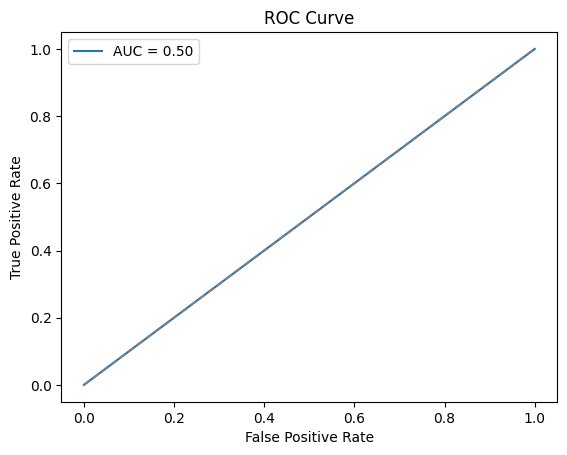

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix,
                             classification_report, roc_auc_score, roc_curve)
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset
import matplotlib.pyplot as plt

# 1. Tạo dữ liệu mẫu hoặc thay bằng dữ liệu thực
# X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
#                            weights=[0.85, 0.15], flip_y=0, random_state=42)

# 2. Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("Phân phối ban đầu:", dict(zip(*np.unique(y_train, return_counts=True))))

# 3. Chuyển về DataFrame và thêm nhãn
df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X.shape[1])])
df_train['churn'] = y_train

# 4. Lọc lớp thiểu số (churn = 1)
df_minority = df_train[df_train['churn'] == 1]

# 5. Số lượng cần sinh thêm
majority_count = df_train['churn'].value_counts()[0]
minority_count = df_train['churn'].value_counts()[1]
num_samples_to_generate = majority_count - minority_count

# 6. Khởi tạo metadata cho dữ liệu
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_minority)

# 7. Huấn luyện mô hình sinh dữ liệu
model = SingleTablePreset(name='FAST_ML', metadata=metadata)
model.fit(df_minority)

# 8. Sinh dữ liệu mới
synthetic_data = model.sample(num_rows=num_samples_to_generate)
print(f"Đã sinh {len(synthetic_data)} bản ghi bằng SDV.")

# 9. Gộp lại dữ liệu gốc và dữ liệu sinh
df_augmented = pd.concat([df_train, synthetic_data], ignore_index=True)

# 10. Tách lại X, y
X_resampled = df_augmented.drop(columns=['churn']).values
y_resampled = df_augmented['churn'].values

# 11. Kiểm tra phân phối mới
print("Phân phối sau GAN:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 12. Huấn luyện mô hình
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

# 13. Dự đoán và đánh giá
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 14. Vẽ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
